# Introduction

This notebook implements a multi-scale approach to **Detecting Cancer Metastases on Gigapixel Pathology Images** ([paper](https://arxiv.org/abs/1703.02442))

We use the images extracted from the slides using the notebook **Data Preparation.ipynb**

- Name: Smarth Gupta
- UNI: sg3868
- Course: Applied Deep Learning 

### Imports

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import tensorflow as tf

In [ ]:
from openslide import open_slide, __library_version__ as openslide_version
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os
import pathlib
from google.colab import drive
from skimage.color import rgb2gray

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, concatenate, Input, Dense, Dropout, BatchNormalization 
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics as sk_metrics
from sklearn.metrics import confusion_matrix

In [ ]:
BATCH_SIZE = 16
WINDOW_SIZE = 80
CENTER_SIZE = 50
ZOOM_LEVEL_1 = 3
ZOOM_LEVEL_2 = 4

### Mount Drive

To load preprocessed images

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
drive_path = "/gdrive/MyDrive/applied-slides"
sz = 80
train_zoom_1 = np.load(f"{drive_path}/train_{sz}_fin_2/zoom_1.npy", allow_pickle=True)
train_zoom_2 = np.load(f"{drive_path}/train_{sz}_fin_2/zoom_2.npy", allow_pickle=True)
train_label = np.load(f"{drive_path}/train_{sz}_fin_2/labels.npy", allow_pickle=True)

val_zoom_1 = np.load(f"{drive_path}/val_{sz}_fin_2/zoom_1.npy", allow_pickle=True)
val_zoom_2 = np.load(f"{drive_path}/val_{sz}_fin_2/zoom_2.npy", allow_pickle=True)
val_label = np.load(f"{drive_path}/val_{sz}_fin_2/labels.npy", allow_pickle=True)

In [ ]:
assert train_zoom_1.shape == train_zoom_2.shape
assert len(train_zoom_1) == len(train_label)

assert val_zoom_1.shape == val_zoom_2.shape
assert len(val_zoom_1) == len(val_label)

In [ ]:
print(train_zoom_1.shape)
print(val_zoom_1.shape)

(32580, 80, 80, 3)
(3112, 80, 80, 3)


### Data Augmentation 

In [ ]:
#This function applies random brightness, saturation, hue, and constrast to the training images
# The Max Delta Values have been taken directly from the paper
def data_augmentation(img):
    img = tf.image.random_brightness(img, 64.0/255)
    img = tf.image.random_saturation(img, 0.75, 1)
    img = tf.image.random_hue(img, 0.04)
    img = tf.image.random_contrast(img, 0.50, 1)
    return img
    
#This function applies orthogonal rotation transformations to the training data
def orthogonal_rotations(img):
    return np.rot90(img, np.random.choice([-1, 0, 1, 2]))

# The function maps the pixel values between (-1, 1)
def rescale(image):
    image = image / 255.0
    image = (image - 0.5) * 2
    return image

def preprocess(image):
    image = orthogonal_rotations(image)
    image = data_augmentation(image)
    image = rescale(image)
    return image

In [ ]:
#Define the image generators with efficient data augmentation
train_generator = ImageDataGenerator(horizontal_flip = True,
                                    vertical_flip = True,
                                    preprocessing_function=preprocess) 

validation_generator = ImageDataGenerator(preprocessing_function=rescale)

In [ ]:
#Approach inspired from Source: https://stackoverflow.com/a/66129711

def multi_scale_train_generator(img1, img2, label, random_seed = 176):
    gen_zoom_1 = train_generator.flow(img1,label, seed = random_seed, batch_size=BATCH_SIZE)
    gen_zoom_2 = train_generator.flow(img2, seed = random_seed, batch_size=BATCH_SIZE)
    while True:
      im_1_i = gen_zoom_1.next()
      im_2_i = gen_zoom_2.next()
      yield [im_1_i[0], im_2_i], im_1_i[1]

def multi_scale_validation_generator(img1, img2, label, random_seed = 176):
    gen_zoom_1 = validation_generator.flow(img1,label, seed = random_seed, batch_size=BATCH_SIZE)
    gen_zoom_2 = validation_generator.flow(img2, seed = random_seed, batch_size=BATCH_SIZE)
    while True:
      im_1_i = gen_zoom_1.next()
      im_2_i = gen_zoom_2.next()
      yield [im_1_i[0], im_2_i], im_1_i[1]

### Initialize Image Generators and explore the data set

In [ ]:
train_data = multi_scale_train_generator(train_zoom_1, train_zoom_2, train_label)
validation_data = multi_scale_validation_generator(val_zoom_1, val_zoom_2, val_label)

1


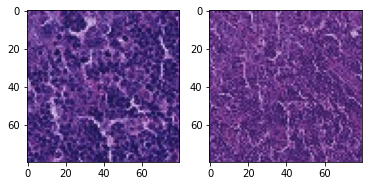

0


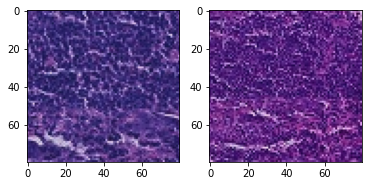

0


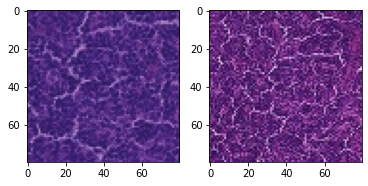

0


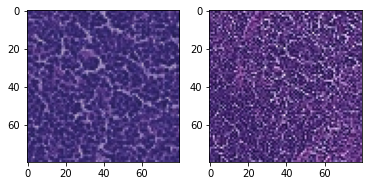

1


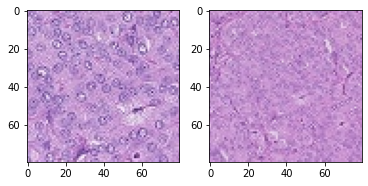

0


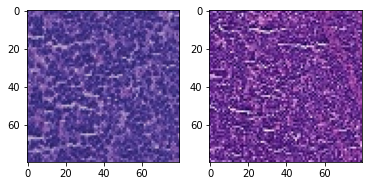

1


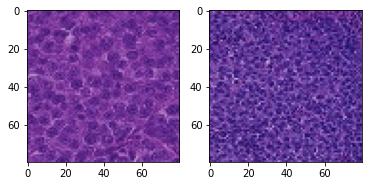

1


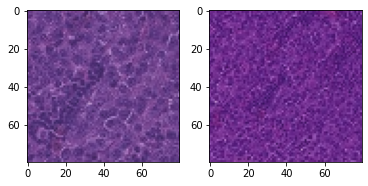

1


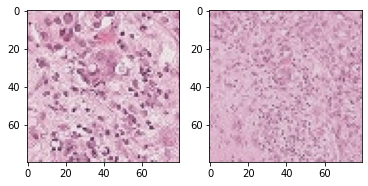

0


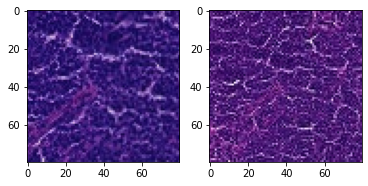

0


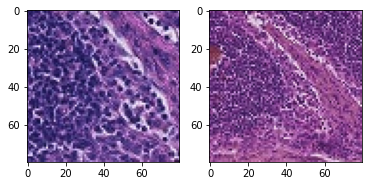

0


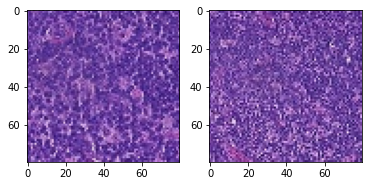

0


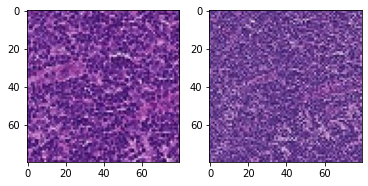

1


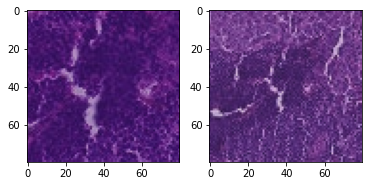

0


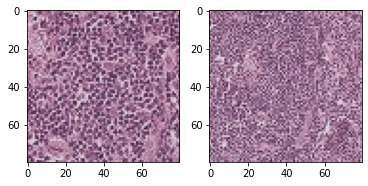

0


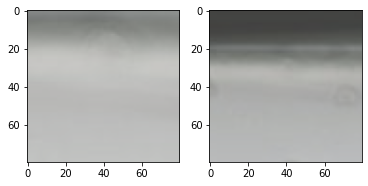

In [ ]:
count = 0
for x, y in train_data:
  count += 1
  for i in range(16):
    print(y[i])
    if y[i] == 0:
      plt.title(f"Multi Magnification Slides of Healthy Cells")

    if y[i] == 1:
      plt.title(f"Multi Magnification Slides of Tumor Cells")
    plt.subplot(1, 2, 1)
    plt.imshow((x[0][i]+1)/2)
    plt.subplot(1, 2, 2)
    plt.imshow((x[1][i]+1)/2)
    plt.show()
    # break
  break

# Model Definition 

In [ ]:
def generate_model():

  # Define Inception Model for Zoom 1
  input_1 = Input(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

  inception_zoom_1 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

  inception_zoom_1.trainable = True

  for layer in inception_zoom_1.layers[:150]:
    layer.trainable = False

  model_1 = Sequential()
  model_1.add(inception_zoom_1)
  model_1.add(GlobalAveragePooling2D())

  model_1 = model_1(input_1)

  # Define Inception Model for Zoom 2
  input_2 = Input(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

  inception_zoom_2 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(WINDOW_SIZE, WINDOW_SIZE, 3))
  inception_zoom_2.trainable = True

  for layer in inception_zoom_2.layers[:150]:
    layer.trainable = False

  model_2 = Sequential()
  model_2.add(inception_zoom_2)
  model_2.add(GlobalAveragePooling2D())

  model_2 = model_2(input_2)

  # Merge the two models
  merged_model = concatenate([model_1, model_2])

  # Add top level classification layers
  dense_layer_1 = Dense(256, activation='relu')(merged_model)
  dropout_layer = Dropout(0.3)(dense_layer_1)
  dense_layer_2 = Dense(128, activation='relu')(dropout_layer)

  output = Dense(1, activation='sigmoid')(dense_layer_2)
  model = Model(inputs=[input_1, input_2], outputs=output)

  return model

In [ ]:
model = generate_model()
model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         21802784    input_3[0][0]                    
_____________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.002), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

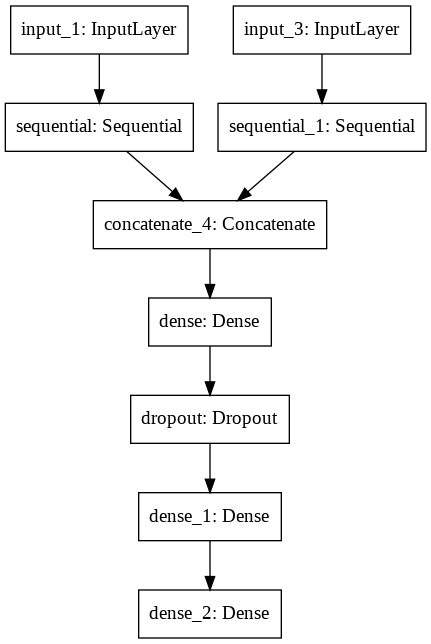

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train On Batch

We train a single batch of images to make sure our model is working fine.

In [ ]:
(zoom_1, zoom_2), label = next(iter(train_data))

In [ ]:
loss = []
accuracy = []
for i in range(30):
  metrics = model.train_on_batch([zoom_1, zoom_2], label)
  loss.append(metrics[0])
  accuracy.append(metrics[1])

In [ ]:
print(accuracy[-1], loss[-1])

1.0 8.346287927452067e-07


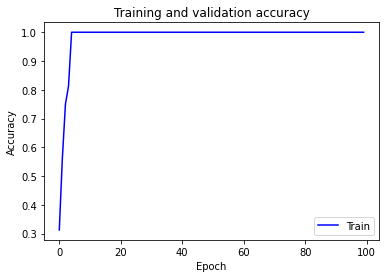

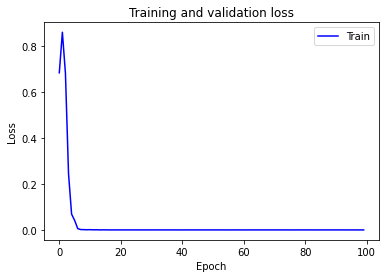

In [ ]:
  # Get the number of epochs
  def plot(accuracy, loss):
    epochs = range(30)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, accuracy, color='blue', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot(accuracy, loss)

### Create Checkpoint Directory

In [ ]:
drive_root = '/gdrive/My Drive/'
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "final-project-checkpoints-2")
# epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [ ]:
# Restore Latest Checkpoint
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/final-project-checkpoints-2
Creating a checkpoints directory


### Train Model

In [ ]:
# Define Checkpoint Callback
check_point_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, monitor='val_accuracy',
                                                 verbose=1)

In [ ]:
# This will reduce the learning rate as the validation loss curve flattens
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)

# This is for efficient Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  verbose=1)

In [ ]:
model = generate_model()

model.compile(optimizer=Adam(learning_rate=0.002), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data, 
                    steps_per_epoch = len(train_zoom_1) / BATCH_SIZE, 
                    validation_steps=len(val_zoom_1) / BATCH_SIZE, 
                    callbacks = [check_point_callback, early_stopping, reduce_learning_rate])

Epoch 1/20
2036/2036 [==============================] - 195s 90ms/step - loss: 0.4724 - accuracy: 0.8222 - val_loss: 0.6395 - val_accuracy: 0.4913

Epoch 00001: saving model to /gdrive/My Drive/checkpoints/final-project-checkpoints-2/cp-00000001.ckpt
Epoch 2/20
2036/2036 [==============================] - 178s 87ms/step - loss: 0.3271 - accuracy: 0.8663 - val_loss: 0.4036 - val_accuracy: 0.8795

Epoch 00002: saving model to /gdrive/My Drive/checkpoints/final-project-checkpoints-2/cp-00000002.ckpt
Epoch 3/20
2036/2036 [==============================] - 179s 88ms/step - loss: 0.2309 - accuracy: 0.9011 - val_loss: 0.3278 - val_accuracy: 0.8352

Epoch 00003: saving model to /gdrive/My Drive/checkpoints/final-project-checkpoints-2/cp-00000003.ckpt
Epoch 4/20
2036/2036 [==============================] - 178s 87ms/step - loss: 0.2142 - accuracy: 0.9138 - val_loss: 0.2818 - val_accuracy: 0.8885

Epoch 00004: saving model to /gdrive/My Drive/checkpoints/final-project-checkpoints-2/cp-00000004.c

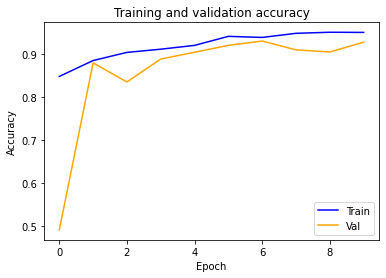

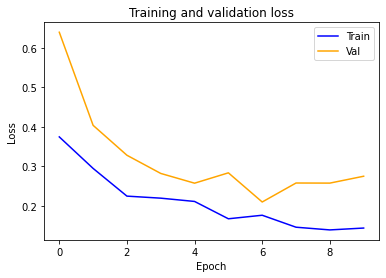

In [ ]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [ ]:
#Load Final Model Weights
model = generate_model()
model.load_weights('/gdrive/My Drive/checkpoints/final-project-checkpoints-2/cp-00000010.ckpt')

### Define Functions for Prediction on Slides

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):

    try:
      im = slide.read_region((x,y), level, (width, height))
    except:
      print(x, y, level, width, height)

    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def predict_on_slide(slide, slide_mask, level_1, level_2, window_size, center_size, stride):


  tumor_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_1, 
                         width=tumor.level_dimensions[level_1][0], 
                         height=tumor.level_dimensions[level_1][1])
  
  tumor_mask_image = read_slide(slide_mask, 
                         x=0, 
                         y=0, 
                         level=level_1, 
                         width=tumor.level_dimensions[level_1][0], 
                         height=tumor.level_dimensions[level_1][1])
  
  tumor_image_2 = read_slide(slide, 
                        x=0, 
                        y=0, 
                        level=level_2, 
                        width=tumor.level_dimensions[level_2][0], 
                        height=tumor.level_dimensions[level_2][1])
  
  patch_images_1 = []
  patch_images_2 = []
  patch_center = []
  patch_coord  = []
  tumor_mask_image = tumor_mask_image[:,:,0]
  preds = []
  count = 0
  
  for i in range(window_size//2, slide.level_dimensions[level_1][1] - window_size - stride, stride):
    for j in range(window_size//2, slide.level_dimensions[level_1][0] - window_size - stride, stride):
      patch_1 = tumor_image_1[i:i+window_size, j:j+window_size]
      tumor_mask_patch = tumor_mask_image[i:i+window_size, j:j+window_size]
      patch_images_1.append(patch_1)
      patch_coord.append((j, i))
      center = (j+window_size//2, i+window_size//2)
      patch_2 = tumor_image_2[center[1]//2-window_size//2:center[1]//2+window_size//2, center[0]//2-window_size//2:center[0]//2+window_size//2]
      patch_center.append(center)

      patch_1_ = np.expand_dims(kp_image.img_to_array(patch_1)/255.0, axis=0)
      patch_2_ = np.expand_dims(kp_image.img_to_array(patch_2)/255.0, axis=0)

      patches = (patch_1_, patch_2_)
      tissue_pixels = find_tissue_pixels(patch_1)
      tissue_pixels = list(tissue_pixels)
      percent_tissue = len(tissue_pixels) / float(patch_1.shape[1] * patch_1.shape[1]) * 100
      if percent_tissue < 50:
        y_pred = 0
      else:
        y_pred = model.predict(patches)[0][0]
      preds.append(y_pred)
      count += 1
      if count % 100 == 0:
        print(".", end = "")
      if count % 2000 == 0:
        print("\n", count, end = " | ")
   
  return patch_images_1, patch_images_2, patch_coord, preds

In [ ]:
def generate_prediction_mask(y_pred, window_size,center_size,stride, slide, patch_coord, level_1):
  
  mask_size = tumor.level_dimensions[level_1]

  tumor_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_1, 
                         width=tumor.level_dimensions[level_1][0], 
                         height=tumor.level_dimensions[level_1][1])

  mask_pred=np.zeros((mask_size[1],mask_size[0]))
  count=0
  x_grid=center_size//2
  y_grid=center_size//2
  print(len(y_pred))

  for i in range(len(y_pred)):
    center = (patch_coord[i][0]+window_size//2, patch_coord[i][1]+window_size//2)
    mask_pred[(center[1]-x_grid):(center[1]+x_grid),(center[0]-y_grid):(center[0]+y_grid)]=y_pred[i]
    count += 1
  print(count)
  return(mask_pred)

In [ ]:
def plot_results(slide_image, mask_image, mask_prediction):
  plt.figure(figsize=(10,10), dpi=100)
  plt.subplot(1,2,1)
  plt.imshow(slide_image)
  plt.imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)
  plt.subplot(1,2,2)
  plt.imshow(slide_image)
  plt.imshow(mask_prediction, cmap='jet',alpha=0.5) # Red regions contains cancer.
  plt.show()


In [ ]:
# Source: https://stackoverflow.com/a/43043378
def evaluate_model(mask_image, mask_pred):
  fpr, tpr, thresholds = sk_metrics.roc_curve(mask_image[:,:,0].reshape(-1).astype('float32'), 
                                         mask_pred.reshape(-1), pos_label=None)
  
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr)
  plt.show()
  
  thres = thresholds[np.argmax(1-fpr+tpr)]
  print('1) AUC:%s'%(sk_metrics.auc(fpr, tpr)))
  print('2) Threshold:{}'.format(thres))
  print('3) Sensitivity:{}'.format(tpr[np.argmax(1-fpr+tpr)]))
  print('4) Specificity:{}'.format((1-fpr)[np.argmax(1-fpr+tpr)]))
  
  mask_pred_labels = np.zeros(mask_pred.shape)
  mask_pred_labels[mask_pred > thres] = 1.
  
  mat = confusion_matrix(mask_image[:,:,0].reshape(-1).astype('uint8'), 
                       mask_pred_labels.reshape(-1).astype('uint8'))
  
  recall = mat[1][1]/(mat[1][1]+mat[1][0])   #tp/tp+fn
  precision = mat[1][1]/(mat[1][1]+mat[0][1])  #tp/tp+fp
  
  print('8) Recall:{}'.format(recall))
  print('9) Precision:{}'.format(precision))

### Prediction on Trained Slides

In [ ]:
slide_path = 'tumor_110.tif' # only this file is available
tumor_mask_path = 'tumor_110_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % slide_path
mask_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0  73.8M      0  0:00:19  0:00:19 --:--:-- 68.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  13.8M      0  0:00:02  0:00:02 --:--:-- 13.8M


In [ ]:
tumor_name = "tumor_110"
tumor = open_slide(f'{tumor_name}.tif')
tumor_mask = open_slide(f'{tumor_name}_mask.tif')
patches, patches_2, coord, pred1= predict_on_slide(tumor, tumor_mask, level_1=ZOOM_LEVEL_1, level_2=ZOOM_LEVEL_2, 
                                window_size=WINDOW_SIZE, center_size=CENTER_SIZE, stride=CENTER_SIZE)

....................
 2000 | ....................
 4000 | ....................
 6000 | ....................
 8000 | ....................
 10000 | ....................
 12000 | ....................
 14000 | ....................
 16000 | ....................
 18000 | ....................
 20000 | ....................
 22000 | ....................
 24000 | ....................
 26000 | ....................
 28000 | ....................
 30000 | ....................
 32000 | ....................
 34000 | ....................
 36000 | ....................
 38000 | ....................
 40000 | ..........

In [ ]:
prediction_mask = generate_prediction_mask(np.asarray(pred1), window_size = 80, 
                         center_size=50, stride = 50, slide=tumor, patch_coord=coord,
                         level_1=3)

41008
41008


In [ ]:
slide_image = np.asarray(read_slide(tumor, x=0, y=0, 
                         level=3, 
                         width=tumor.level_dimensions[3][0], 
                         height=tumor.level_dimensions[3][1]))
mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                        level=3, 
                        width=tumor_mask.level_dimensions[3][0], 
                        height=tumor_mask.level_dimensions[3][1]))

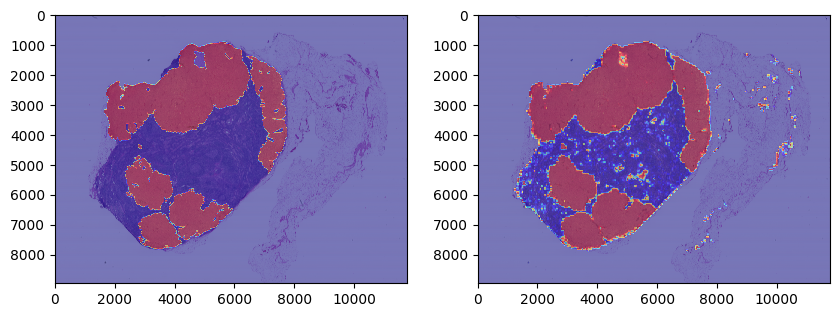

In [ ]:
plot_results(slide_image, mask_image, prediction_mask)

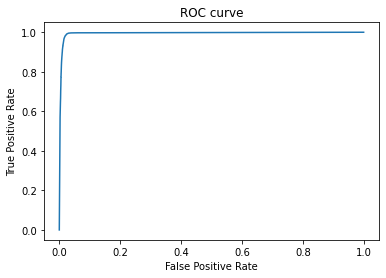

1) AUC:0.9945704478763616
2) Threshold:0.7244561314582825
3) Sensitivity:0.9916178299480929
4) Specificity:0.9751450081957578
8) Recall:0.9915595900372304
9) Precision:0.8805702793899312


In [ ]:
evaluate_model(mask_image, prediction_mask)

### Predicted on New Slide

In [ ]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % slide_path
mask_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  64.8M      0  0:00:08  0:00:08 --:--:-- 85.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  16.7M      0 --:--:-- --:--:-- --:--:-- 16.7M


In [ ]:
tumor_name = "tumor_091"
tumor = open_slide(f'{tumor_name}.tif')
tumor_mask = open_slide(f'{tumor_name}_mask.tif')
test_patches, test_patches_2, test_coord, test_pred1= predict_on_slide(tumor, tumor_mask, level_1=ZOOM_LEVEL_1, level_2=ZOOM_LEVEL_2, 
                                                                        window_size=WINDOW_SIZE, center_size=CENTER_SIZE, stride=CENTER_SIZE)

....................
 2000 | ....................
 4000 | ....................
 6000 | ....................
 8000 | ....................
 10000 | ....................
 12000 | ....................
 14000 | ....................
 16000 | ....................
 18000 | .................

In [ ]:
prediction_mask_test = generate_prediction_mask(np.asarray(test_pred1), window_size = 80, 
                         center_size=50, stride = 50, slide=tumor, patch_coord=test_coord,
                         level_1=ZOOM_LEVEL1)

19781
19781


In [ ]:
slide_image_test = np.asarray(read_slide(tumor, x=0, y=0, 
                         level=ZOOM_LEVEL1, 
                         width=tumor.level_dimensions[ZOOM_LEVEL1][0], 
                         height=tumor.level_dimensions[ZOOM_LEVEL1][1]))
mask_image_test = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                        level=ZOOM_LEVEL13, 
                        width=tumor_mask.level_dimensions[ZOOM_LEVEL1][0], 
                        height=tumor_mask.level_dimensions[ZOOM_LEVEL1][1]))

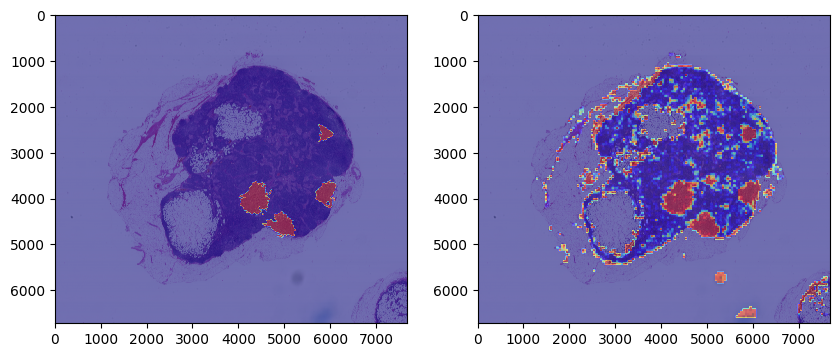

In [ ]:
plot_results(slide_image_test, mask_image_test, prediction_mask_test)

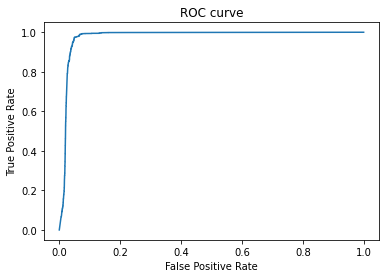

1) AUC:0.9765994795293569
2) Threshold:0.4842933714389801
3) Sensitivity:0.9747825482617226
4) Specificity:0.9500474505335954
8) Recall:0.972775095828455
9) Precision:0.22275195103289977


In [ ]:
evaluate_model(mask_image_test, prediction_mask_test)